# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import numpy as np, pandas as pd
from glob import glob
import shutil, os
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm
import seaborn as sns
from sklearn import preprocessing
import random
import math
import pickle
import torch
from os import listdir
from os.path import isfile, join
import yaml
from sklearn.cluster import Birch
import cv2
from IPython.display import Image, clear_output  # to display images
import networkx as nx
from collections import Counter

Mounted at /content/drive


In [ ]:
with open("/content/drive/MyDrive/Colab-Variables/reflacx_with_birch.pkl",'rb') as file:
    _reflacx_birch = pickle.load(file)
with open("/content/drive/MyDrive/Colab-Variables/reflacx_birch_spectral.pkl",'rb') as file:
    _reflacx_birch_spectral = pickle.load(file)
#with open('/content/drive/MyDrive/Colab-Variables/reflacx_gaze.pkl', 'rb') as file:
#    _reflacx_gaze = pickle.load(file)
with open('/content/drive/MyDrive/Colab-Variables/reflacx_fixations.pkl', 'rb') as file:
    _reflacx_fixations = pickle.load(file)
with open('/content/drive/MyDrive/Colab-Variables/reflacx_fixations_sp.pkl', 'rb') as file:
    _reflacx_fixations_sp = pickle.load(file)
with open('/content/drive/MyDrive/Colab-Variables/reflacx_fixations_sl.pkl', 'rb') as file:
    _reflacx_fixations_sl = pickle.load(file)

not_loaded_gazes = ['P106R326531','P107R142617','P107R684577','P108R495584','P114R939040','P115R164105','P127R318478',
                    'P132R987119','P141R986347','P144R615596','P201R760558','P201R763844','P204R050781','P206R702352',
                    'P214R226457','P215R459500','P240R464062','P246R876094','P247R036616','P248R587505']

train_df = pd.DataFrame(pd.read_csv('/content/drive/MyDrive/Colab-Variables/train_df.csv'))
reflacx_meta_df = pd.DataFrame(pd.read_csv('/content/drive/MyDrive/Colab-Variables/reflacx_meta_df.csv'))

In [9]:
reflacx_df = pd.DataFrame(pd.read_csv('/content/drive/MyDrive/Colab-Variables/reflacx_df.csv'))

filter_abnormality = ['Atelectasis','Consolidation','Pulmonary edema','Pleural abnormality','Enlarged cardiac silhouette']

print(len(reflacx_df))
print(len(reflacx_df[(reflacx_df['abnormality'] == 'Atelectasis')]))
print(len(reflacx_df[reflacx_df['abnormality'] == 'Consolidation']))
print(len(reflacx_df[reflacx_df['abnormality'] == 'Pulmonary edema']))
print(len(reflacx_df[reflacx_df['abnormality'] == 'Pleural abnormality']))
print(len(reflacx_df[reflacx_df['abnormality'] == 'Enlarged cardiac silhouette']))

6613
1201
1162
766
1165
716


In [23]:
tmp = reflacx_df[(reflacx_df['abnormality'] == 'Pulmonary edema')]
one = len(tmp[tmp['certain'] == 1])
two = len(tmp[tmp['certain'] == 2])
three = len(tmp[tmp['certain'] == 3])
four = len(tmp[tmp['certain'] == 4])
five = len(tmp[tmp['certain'] == 5])

pe = [one,two,three,four,five]

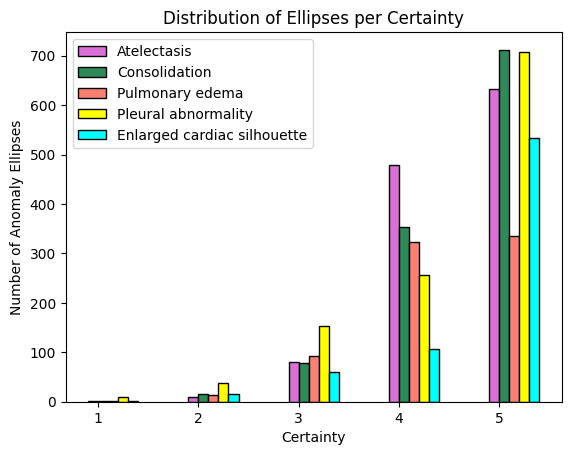

In [31]:
n=5
r = np.arange(n)
width = 0.1


plt.bar(r, a, color = 'orchid', width = width, edgecolor = 'black', label='Atelectasis')
plt.bar(r + width, c, color = 'seagreen', width = width, edgecolor = 'black', label='Consolidation')
plt.bar(r + width*2, pe, color = 'salmon', width = width, edgecolor = 'black', label='Pulmonary edema')
plt.bar(r + width*3, pa, color = 'yellow', width = width, edgecolor = 'black', label='Pleural abnormality')
plt.bar(r + width*4, ecs, color = 'aqua', width = width, edgecolor = 'black', label='Enlarged cardiac silhouette')

plt.xlabel("Certainty")
plt.ylabel("Number of Anomaly Ellipses")
plt.title("Distribution of Ellipses per Certainty")

# plt.grid(linestyle='--')
plt.xticks(r + width/2,['1','2','3','4','5'])
plt.legend()

plt.show()

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%ls
%pip install -qr requirements.txt  # install

import torch
from IPython.display import Image, clear_output  # to display images

clear_output()

In [ ]:
ids = reflacx_meta_df['id']
birch_fixations = "/content/drive/MyDrive/MIMIC-Eye-applications-main/birch_fixations"
spread_1 = pd.DataFrame(pd.read_csv('/content/drive/MyDrive/MIMIC-Eye-applications-main/spreadsheets/reflacx_eye.csv'))
spread_2 = pd.DataFrame(pd.read_csv('/content/drive/MyDrive/MIMIC-Eye-applications-main/spreadsheets/reflacx_clinical_eye.csv'))
for id in ids:
    if id not in _reflacx_birch_spectral.keys():
        spread_1 = spread_1[spread_1.id != id]
        spread_2 = spread_2[spread_2.id != id]

In [ ]:
len(reflacx_meta_df)

3052

# Prepare the Dataset
Using cxr_meta.csv and .../Reflacx/metadata_update.csv create a Pandas Dataframe containing all the relevant information to manipulate the data provided to YOLO.

The most important values per row include: the study id, image size, the coordinates of the bounding box corresponding to one abnormality reported by a radiologist, the abnormality name and the corresponding abnormality id, and a folder to split the data.

In [ ]:
meta_path = "/content/drive/MyDrive/XAMI-MIMIC/spreadsheets/cxr_meta.csv"
cxr_meta_df = pd.DataFrame(pd.read_csv(meta_path))
meta_df = cxr_meta_df[cxr_meta_df.in_reflacx == True]
remove_cols = ['PerformedProcedureStepDescription','ViewPosition','StudyDate','StudyTime','ProcedureCodeSequence_CodeMeaning','ViewCodeSequence_CodeMeaning','PatientOrientationCodeSequence_CodeMeaning','in_eye_gaze','in_reflacx','StudyDateTime','stay_id']
meta_df = meta_df.drop(remove_cols,1)

meta_path = "/content/drive/MyDrive/XAMI-MIMIC/spreadsheets/REFLACX/metadata_updated.csv"
reflacx_meta_df = pd.DataFrame(pd.read_csv(meta_path))
remove_cols = ['split','eye_tracking_data_discarded','image']
reflacx_meta_df = reflacx_meta_df.drop(remove_cols,1)
reflacx_meta_df = reflacx_meta_df.iloc[:, :reflacx_meta_df.columns.get_loc('image_size_y') + 1]

reflacx_meta_df = pd.merge(reflacx_meta_df,meta_df[['dicom_id','study_id']], on='dicom_id', how='left')

reflacx_meta_df.to_csv('/content/drive/MyDrive/Colab-Variables/reflacx_meta_df.csv',index=False)

<ipython-input-10-7bce434ac312>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  meta_df = meta_df.drop(remove_cols,1)
<ipython-input-10-7bce434ac312>:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  reflacx_meta_df = reflacx_meta_df.drop(remove_cols,1)


In [ ]:
reflacx_meta_df = pd.DataFrame(pd.read_csv('/content/drive/MyDrive/Colab-Variables/reflacx_meta_df.csv'))
reflacx_meta_df.head()

,id,dicom_id,subject_id,image_size_x,image_size_y,study_id
0,P102R108387,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,2544,3056,55032240
1,P102R379837,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,2544,3056,55032240
2,P102R558314,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,2544,3056,55032240
3,P102R765317,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,2544,3056,55032240
4,P102R915878,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,2544,3056,55032240


In [ ]:
root_dir = "/content/drive/MyDrive/XAMI-MIMIC/"

column_names = ['patient_id','id','study_id','dicom_id','width','height','abnormality','certain','xmin_e','xmax_e','ymin_e','ymax_e']
new_df = pd.DataFrame(columns = column_names)

XMIN = 0
YMIN = 1
XMAX = 2
YMAX = 3

for idx, row in reflacx_meta_df.iterrows():
    ellipses_path = root_dir + 'patient_' + str(row.subject_id) + '/REFLACX/' + str(row.id) + '/anomaly_location_ellipses.csv'
    ellipses_df = pd.DataFrame(pd.read_csv(ellipses_path))
    for ell_idx, ell_row in ellipses_df.iterrows():
        ell_row_df = pd.DataFrame(ell_row)
        if True in ell_row_df.values:
            selected_columns = list((ell_row_df.iloc[np.where(ell_row_df == True)]).index)
            for label in selected_columns:
                new_df.loc[len(new_df.index)] = [row.subject_id,row.id,row.study_id,row.dicom_id,row.image_size_x,row.image_size_y,
                                 label,ell_row[4],ell_row[XMIN],ell_row[XMAX],ell_row[YMIN],ell_row[YMAX]]
new_df

,patient_id,id,study_id,dicom_id,width,height,abnormality,certain,xmin_e,xmax_e,ymin_e,ymax_e
0,18111516,P102R108387,55032240,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,2544,3056,Enlarged cardiac silhouette,5.0,734,2211,1204,2175
1,18111516,P102R379837,55032240,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,2544,3056,Enlarged cardiac silhouette,5.0,831,2223,1204,2310
2,18111516,P102R558314,55032240,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,2544,3056,Airway wall thickening,4.0,357,1006,1224,2242
3,18111516,P102R558314,55032240,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,2544,3056,Enlarged cardiac silhouette,5.0,692,2257,1364,2261
4,18111516,P102R765317,55032240,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,2544,3056,certainty,1.0,451,579,2114,2240
...,...,...,...,...,...,...,...,...,...,...,...,...
6608,19997367,P300R510107,58801152,1bdf3180-0209f001-967acab6-0b811ea2-3c2e13eb,2532,2539,Atelectasis,5.0,421,1039,1225,1949
6609,19997367,P300R510107,58801152,1bdf3180-0209f001-967acab6-0b811ea2-3c2e13eb,2532,2539,Pulmonary edema,5.0,421,1039,1225,1949
6610,19997367,P300R510107,58801152,1bdf3180-0209f001-967acab6-0b811ea2-3c2e13eb,2532,2539,Atelectasis,5.0,1399,2173,1235,2056
6611,19997367,P300R510107,58801152,1bdf3180-0209f001-967acab6-0b811ea2-3c2e13eb,2532,2539,Pulmonary edema,5.0,1399,2173,1235,2056


In [ ]:
new_df.to_csv('/content/drive/MyDrive/Colab-Variables/reflacx_df.csv',index=False)

In [ ]:
train_df = pd.DataFrame(pd.read_csv('/content/drive/MyDrive/Colab-Variables/reflacx_df.csv'))
train_df.head()

,patient_id,id,study_id,dicom_id,width,height,abnormality,xmin_e,xmax_e,ymin_e,ymax_e
0,18111516,P102R108387,55032240,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,2544,3056,Enlarged cardiac silhouette,734,2211,1204,2175
1,18111516,P102R379837,55032240,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,2544,3056,Enlarged cardiac silhouette,831,2223,1204,2310
2,18111516,P102R558314,55032240,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,2544,3056,Airway wall thickening,357,1006,1224,2242
3,18111516,P102R558314,55032240,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,2544,3056,Enlarged cardiac silhouette,692,2257,1364,2261
4,18111516,P102R765317,55032240,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,2544,3056,Nodule,451,579,2114,2240


In [ ]:
# create x_min, x_max that are normalized
train_df['x_min'] = train_df.apply(lambda row: (row.xmin_e)/row.width, axis=1)
train_df['x_max'] = train_df.apply(lambda row: (row.xmax_e)/row.width, axis=1)

# create y_min, y_max that are normalized
train_df['y_min'] = train_df.apply(lambda row: (row.ymin_e)/row.height, axis=1)
train_df['y_max'] = train_df.apply(lambda row: (row.ymax_e)/row.height, axis=1)

# calculate w and h (width and height of the bb of the ellipse)
train_df['w'] = train_df.apply(lambda row: abs(row.x_max - row.x_min), axis=1)
train_df['h'] = train_df.apply(lambda row: abs(row.y_max - row.y_min), axis=1)

# also add x_mid and y_mid
train_df['x_mid'] = train_df.apply(lambda row: (row.x_max + row.x_min)/2, axis =1)
train_df['y_mid'] = train_df.apply(lambda row: (row.y_max + row.y_min)/2, axis =1)

# calculate the area
train_df['area'] = train_df['w'] * train_df['h']

# Label encode all the bounding boxes name
train_df['abnormality_id'] = 0

train_df.head()

,patient_id,id,study_id,dicom_id,width,height,abnormality,xmin_e,xmax_e,ymin_e,...,x_min,x_max,y_min,y_max,w,h,x_mid,y_mid,area,abnormality_id
0,18111516,P102R108387,55032240,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,2544,3056,Enlarged cardiac silhouette,734,2211,1204,...,0.288522,0.869104,0.393979,0.711715,0.580582,0.317736,0.578813,0.552847,0.184471,0
1,18111516,P102R379837,55032240,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,2544,3056,Enlarged cardiac silhouette,831,2223,1204,...,0.326651,0.873821,0.393979,0.755890,0.547170,0.361911,0.600236,0.574935,0.198027,0
2,18111516,P102R558314,55032240,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,2544,3056,Airway wall thickening,357,1006,1224,...,0.140330,0.395440,0.400524,0.733639,0.255110,0.333115,0.267885,0.567081,0.084981,0
3,18111516,P102R558314,55032240,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,2544,3056,Enlarged cardiac silhouette,692,2257,1364,...,0.272013,0.887186,0.446335,0.739856,0.615173,0.293521,0.579599,0.593096,0.180566,0
4,18111516,P102R765317,55032240,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,2544,3056,Nodule,451,579,2114,...,0.177280,0.227594,0.691754,0.732984,0.050314,0.041230,0.202437,0.712369,0.002074,0


In [ ]:
image_path = {}

# add to dic
for idx, row in train_df.iterrows():
    image_path[row['id']] = "/content/drive/MyDrive/XAMI-MIMIC/patient_" + str(row['patient_id']) + "/CXR-JPG/s" + str(row['study_id']) + "/" + str(row['dicom_id']) + ".jpg"

# add dic to df
train_df['image_path'] = train_df['id'].map(image_path)

# Create a new DataFrame with unique labels and their corresponding integer IDs
label_mapping = pd.DataFrame({'abnormality': train_df['abnormality'].unique(), 'abnormality_id': range(len(train_df['abnormality'].unique()))})

# Merge the original DataFrame with the label mapping DataFrame
train_df = pd.merge(train_df, label_mapping, on='abnormality', how='left')

# Select the desired column and rename it
train_df['abnormality_id'] = train_df['abnormality_id_y']
train_df.drop(['abnormality_id_x', 'abnormality_id_y'], axis=1, inplace=True)

# Create a new column Folder and randomly assign each report to a folder (kfold cross validation)
gkf = GroupKFold(n_splits=5)
train_df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(gkf.split(train_df, groups = train_df.dicom_id.tolist())):
    train_df.loc[val_idx, 'fold'] = fold

train_df.to_csv('/content/drive/MyDrive/Colab-Variables/train_df.csv',index=False)
train_df.head()

,patient_id,id,study_id,dicom_id,width,height,abnormality,xmin_e,xmax_e,ymin_e,...,y_min,y_max,w,h,x_mid,y_mid,area,image_path,abnormality_id,fold
0,18111516,P102R108387,55032240,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,2544,3056,Enlarged cardiac silhouette,734,2211,1204,...,0.393979,0.711715,0.580582,0.317736,0.578813,0.552847,0.184471,/content/drive/MyDrive/DiogoB/Images/Original/...,0,1
1,18111516,P102R379837,55032240,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,2544,3056,Enlarged cardiac silhouette,831,2223,1204,...,0.393979,0.755890,0.547170,0.361911,0.600236,0.574935,0.198027,/content/drive/MyDrive/DiogoB/Images/Original/...,0,1
2,18111516,P102R558314,55032240,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,2544,3056,Airway wall thickening,357,1006,1224,...,0.400524,0.733639,0.255110,0.333115,0.267885,0.567081,0.084981,/content/drive/MyDrive/DiogoB/Images/Original/...,1,1
3,18111516,P102R558314,55032240,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,2544,3056,Enlarged cardiac silhouette,692,2257,1364,...,0.446335,0.739856,0.615173,0.293521,0.579599,0.593096,0.180566,/content/drive/MyDrive/DiogoB/Images/Original/...,0,1
4,18111516,P102R765317,55032240,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,2544,3056,Nodule,451,579,2114,...,0.691754,0.732984,0.050314,0.041230,0.202437,0.712369,0.002074,/content/drive/MyDrive/DiogoB/Images/Original/...,2,1


#Get Train and Val Images Names

In [ ]:
img_train_path = '/content/drive/MyDrive/DiogoB/yolo_models/fixations250/images/train'
img_val_path = '/content/drive/MyDrive/DiogoB/yolo_models/fixations250/images/val'

# Get a list of file names in the directory
train_names = os.listdir(img_train_path)
val_names = os.listdir(img_val_path)

# Remove the ".txt" extension from each file name
train_names = [file_name.replace('.jpg', '') for file_name in train_names]
val_names = [file_name.replace('.jpg', '') for file_name in val_names]

2089


# Prepare the Images with BIRCH
This step is done by using the gaze.csv and the BIRCH clustering algorithm to generate clusters representing the radiologist's search behaviour.
After have the centroids of these clusters, an algorithm is applied to crop the entire image, leaving only squares centered on the centroids with size roi_size

In [ ]:
# Set the size of the square region of interest (ROI) roi_size = 40
roi_size = 350 #90.5472

root_dir = "/content/drive/MyDrive/XAMI-MIMIC/patient_"
folder = 'birch' + str(roi_size)
os.makedirs('/content/drive/MyDrive/DiogoB/images/'+ folder, exist_ok = True)

def imageBIRCH(image, space_points, id):
    save_img_path = '/content/drive/MyDrive/DiogoB/Images/'+ folder + '/' + str(id) + '.jpg'

    black_image = np.zeros_like(image)

    # Iterate over the squares and set the region of interest (ROI) in the black image
    for centroid in centroid_points:
        # Retrieve the position and size of the square
        mid_size = roi_size/2
        # Calculate the coordinates of the square's bounding box
        x, y = centroid[0]-mid_size, centroid[1]-mid_size
        x_end = int(x + roi_size)
        y_end = int(y + roi_size)
        x = int(x)
        y = int(y)
        # Set the region of interest (ROI) in the black image
        black_image[y:y_end, x:x_end] = image[y:y_end, x:x_end]

    # Save the black image with the selected squares
    cv2.imwrite(save_img_path, black_image)

for index, row in tqdm(reflacx_meta_df.iterrows()):
    key = row['id']
    centroid_points = _reflacx_birch.get(key)  # Assuming _reflacx_birch is a dictionary

    if centroid_points is not None:
        img_path = root_dir + str(row['subject_id']) + "/CXR-JPG/s" + str(row['study_id']) + "/" + str(row['dicom_id']) + ".jpg"
        image = cv2.imread(img_path)
        imageBIRCH(image, centroid_points, key)
"""
for key, centroid_points in tqdm(_reflacx_birch.items()):
    row = reflacx_meta_df.loc[reflacx_meta_df['id'] == key].iloc[0]
    img_path = root_dir + str(row['subject_id']) + "/CXR-JPG/s" + str(row['study_id']) + "/" + str(row['dicom_id']) + ".jpg"
    image = cv2.imread(img_path)
    imageBIRCH(image, centroid_points, row.id)
"""

#Prepare Images with REFLACX Fixations

In [ ]:
roi_size = 50 #90.5472

root_dir = "/content/drive/MyDrive/XAMI-MIMIC/patient_"
folder = 'fixations' + str(roi_size)
os.makedirs('/content/drive/MyDrive/DiogoB/images/'+ folder, exist_ok = True)

def imageFixations(image, fixation_points, id):
    save_img_path = '/content/drive/MyDrive/DiogoB/images/'+ folder + '/' + str(id) + '.jpg'
    black_image = np.zeros_like(image)

    # Iterate over the squares and set the region of interest (ROI) in the black image
    fixation_points_arr = zip(fixation_points['x_position'].to_numpy(),fixation_points['y_position'].to_numpy())

    for point in fixation_points_arr:
        # Retrieve the position and size of the square
        mid_size = roi_size/2
        # Calculate the coordinates of the square's bounding box
        x, y = point[0]-mid_size, point[1]-mid_size
        x_end = int(x + roi_size)
        y_end = int(y + roi_size)
        x = int(x)
        y = int(y)
        # Set the region of interest (ROI) in the black image
        black_image[y:y_end, x:x_end] = image[y:y_end, x:x_end]

    # Save the black image with the selected squares
    cv2.imwrite(save_img_path, black_image)

for index, row in tqdm(reflacx_meta_df.iterrows()):
    key = row['id']
    # use this to only generate the train images
    if key in train_names:
        fixation_points = _reflacx_fixations.get(key)  # Assuming _reflacx_fixations is a dictionary
        if fixation_points is not None:
            img_path = root_dir + str(row['subject_id']) + "/CXR-JPG/s" + str(row['study_id']) + "/" + str(row['dicom_id']) + ".jpg"
            image = cv2.imread(img_path)
            imageFixations(image, fixation_points, key)

# Dataset Split
In this step, we can create one .txt file per radiologist report. The file has one line per abnormality reported, and each line has the following structure: 'A B C D E \n', where each letter corresponds to, abnormality id, x_center, y_center, weight and height, respectively.

In the next step, we create the folders and copy/move the .jpg and .txt in a way that YOLO can automatically comprehend

    ../dataset/
        labels/                      images/
            train/                      train/
                .txt                        .jpg
            val/                        val/
                .txt                        .jpg

In [ ]:
# Get the unique values of the id column
unique_ids = train_df['id'].unique()

# Filter abnormalities
filter_abnormality = ['Atelectasis','Consolidation','Pulmonary edema','Pleural abnormality','Enlarged cardiac silhouette']
# Create the dir for the .txt labels
os.makedirs('/content/drive/MyDrive/DiogoB/yolo_models/labels', exist_ok = True)

# Iterate over the unique ids and write rows to separate text files
for id_val in tqdm(unique_ids):
    # Filter the DataFrame for the current id
    filtered_df = train_df[train_df['id'] == id_val]

    # Create a file name based on the id
    file_name = f"/content/drive/MyDrive/DiogoB/yolo_models/labels/{id_val}.txt"

    # Open the file in write mode and write the rows
    with open(file_name, 'w') as file:
        file.truncate(0)
        for index, row in filtered_df.iterrows():
            if row.abnormality in filter_abnormality:
                position = filter_abnormality.index(row.abnormality)
                file.write("{} {} {} {} {}\n".format(position, row['x_mid'], row['y_mid'], row['w'], row['h']))
                                                   #(row['abnormality_id'],

  0%|          | 0/2101 [00:00<?, ?it/s]

In [ ]:
fold = 4

train_files = []
val_files   = []
val_files += list(train_df[train_df.fold==fold].image_path.unique())
train_files += list(train_df[train_df.fold!=fold].image_path.unique())

model = 'fixations150'
root_model_img = '/content/drive/MyDrive/DiogoB/images/' + model + '/'

os.makedirs('/content/drive/MyDrive/DiogoB/yolo_models/' + model + '/labels/train', exist_ok = True)
os.makedirs('/content/drive/MyDrive/DiogoB/yolo_models/' + model + '/labels/val', exist_ok = True)
os.makedirs('/content/drive/MyDrive/DiogoB/yolo_models/' + model + '/images/train', exist_ok = True)
os.makedirs('/content/drive/MyDrive/DiogoB/yolo_models/' + model + '/images/val', exist_ok = True)
label_dir = '/content/drive/MyDrive/DiogoB/yolo_models/labels'

for aux in tqdm(train_files):
    filename = aux.split('/')[-1].split('.')[0]
    img_path = root_model_img + filename + '.jpg'
    if os.path.exists(img_path):
        shutil.move(img_path, '/content/drive/MyDrive/DiogoB/yolo_models/' + model + '/images/train')
        shutil.copy(os.path.join(label_dir, filename+'.txt'), '/content/drive/MyDrive/DiogoB/yolo_models/' + model + '/labels/train')

for aux in tqdm(val_files):
    filename = aux.split('/')[-1].split('.')[0]
    img_path = '/content/drive/MyDrive/DiogoB/yolo_models/Baseline/images/val/' + filename + '.jpg'
    if os.path.exists(img_path):
        shutil.copy(img_path, '/content/drive/MyDrive/DiogoB/yolo_models/' + model + '/images/val')
        shutil.copy(os.path.join(label_dir, filename+'.txt'), '/content/drive/MyDrive/DiogoB/yolo_models/' + model + '/labels/val')

shutil.rmtree('/content/drive/MyDrive/DiogoB/images/' + model)

  0%|          | 0/1681 [00:00<?, ?it/s]

  0%|          | 0/420 [00:00<?, ?it/s]

In [ ]:
# To check the count of files and if everything worked fine
dir_path = '/content/drive/MyDrive/DiogoB/yolo_models/fixations150/images/train'

count = 0
for path in os.scandir(dir_path):
    if path.is_file():
        count += 1
print(count)

1671


# YAML, train.txt and val.txt Setup
train.txt and val.txt contain the path to the train/val images (yolo automatically switches the '.../images/...' to '.../labels/...' to find the labels files). The YAML contains the name and number of classes plus the path to the train.txt and val.txt

In [ ]:
#https://docs.ultralytics.com/yolov5/tutorials/train_custom_data/#13-organize-directories

model = 'fixations150'
cwd = '/content/drive/MyDrive/DiogoB/yolo_models/' + model

class_ids, class_names = list(zip(*set(zip(train_df.abnormality_id, train_df.abnormality))))
classes = list(np.array(class_names)[np.argsort(class_ids)])
classes = list(map(lambda x: str(x), classes))

classes = ['Atelectasis','Consolidation','Pulmonary edema','Pleural abnormality','Enlarged cardiac silhouette']

with open(join(cwd, 'train.txt'), 'w') as f:
    for path in glob(cwd + '/images/train/*'):
        f.write(path + '\n')

with open(join(cwd, 'val.txt'), 'w') as f:
    for path in glob(cwd + '/images/val/*'):
        f.write(path + '\n')

data = dict(
    train =  join(cwd, 'train.txt') ,
    val   =  join(cwd, 'val.txt' ),
    nc    = len(classes),
    names = classes
    )

with open(join(cwd, 'reflacx.yaml'), 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

f = open(join(cwd, 'reflacx.yaml'), 'r')
print('\nyaml:')
print(f.read())


yaml:
names:
- Atelectasis
- Consolidation
- Pulmonary edema
- Pleural abnormality
- Enlarged cardiac silhouette
nc: 5
train: /content/drive/MyDrive/DiogoB/yolo_models/fixations150/train.txt
val: /content/drive/MyDrive/DiogoB/yolo_models/fixations150/val.txt



# Main
https://blog.paperspace.com/train-yolov5-custom-data/

In [ ]:
!WANDB_MODE="dryrun" python train.py --img 640 --batch 16 --epochs 10 --data /content/drive/MyDrive/DiogoB/yolo_models/fixations150/reflacx.yaml --weights yolov5x.pt --cache

train: weights=yolov5x.pt, cfg=, data=/content/drive/MyDrive/DiogoB/yolo_models/fixations350/reflacx.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-198-g34c2187 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.

In [ ]:
!zip -r /content/fixations350epochs30.zip /content/yolov5/runs/train/exp2
shutil.move("/content/fixations350epochs30.zip", '/content/drive/MyDrive/fixations350epochs30.zip')

  adding: content/yolov5/runs/train/exp2/ (stored 0%)
  adding: content/yolov5/runs/train/exp2/hyp.yaml (deflated 45%)
  adding: content/yolov5/runs/train/exp2/labels.jpg (deflated 26%)
  adding: content/yolov5/runs/train/exp2/train_batch1.jpg (deflated 17%)
  adding: content/yolov5/runs/train/exp2/weights/ (stored 0%)
  adding: content/yolov5/runs/train/exp2/weights/last.pt (deflated 8%)
  adding: content/yolov5/runs/train/exp2/weights/best.pt (deflated 8%)
  adding: content/yolov5/runs/train/exp2/opt.yaml (deflated 47%)
  adding: content/yolov5/runs/train/exp2/F1_curve.png (deflated 13%)
  adding: content/yolov5/runs/train/exp2/val_batch2_pred.jpg (deflated 12%)
  adding: content/yolov5/runs/train/exp2/val_batch2_labels.jpg (deflated 11%)
  adding: content/yolov5/runs/train/exp2/P_curve.png (deflated 9%)
  adding: content/yolov5/runs/train/exp2/train_batch2.jpg (deflated 18%)
  adding: content/yolov5/runs/train/exp2/labels_correlogram.jpg (deflated 37%)
  adding: content/yolov5/runs/

'/content/drive/MyDrive/fixations350epochs30.zip'